# Modelos de predicción ARIMA

### Modelos AR y MA

En las series temporales, los modelos de autorregresión (AR) y medias móviles (MA) proporcionan una simple descripción de un proceso en dos factores: uno para la autoregresión y el otro para la media móvil. La parte AR implica la regresión de la variable en sus propios valores retrasados. La idea es que el valor del período de tiempo anterior pueda ayudarnos a predecir el valor del período de tiempo actual. La parte MA implica modelar el término de error como una combinación lineal de términos de error que ocurren al mismo paso de tiempo y en varios momentos en el pasado.

### Modelos autorregresivos

El modelo autorregresivo (AR) se da cuando se puede predecir el valor actual de una serie temporal a partir del uso de valores anteriores de la misma serie. Es una regresión usando la propia serie, pero desfasada un periodo, llamado retraso. El valor actual es un promedio ponderado de sus valores pasados. Tanto el ``t-1`` como el ``t-2`` son retrasos (lags) de la serie temporal ``y``. El término de error (ruido) se representa como ``e``. Los valores ``a1`` y ``a2`` son los coeficientes del modelo.

Dependiendo de los retrasos que queramos tener en cuenta, podemos definir diferentes modelos:


Modelo AR(1): $y_{t}$ = $a_{1}$$y_{t-1}$ + $e_{t}$

Modelo AR(2): $y_{t}$ = $a_{1}$$y_{t-1}$ + $a_{2}$$y_{t-2}$ + $e_{t}$

En estos ejemplos, los valores 1 y 2 se corresponden con los retrasos que se tienen en cuenta, que se asocian a la variable ``p``, que nos indicará el orden del modelo AR.


### Modelos de media móvil

La media móvil (MA) es un procedimiento donde el valor actual de una serie temporal (``y``) se define como una combinación lineal de errores pasados. El término de error (ruido) se representa como ``e``. Tanto el ``t-1`` como el ``t-2`` son retrasos del tiempo en los errores.

Modelo MA(1): $y_{t}$ = $m_{1}$$e_{t-1}$ + $e_{t}$

Modleo MA(2): $y_{t}$ = $m_{1}$$e_{t-1}$ + $m_{2}$$e_{t-2}$ + $e_{t}$

En estos ejemplos, los valores 1 y 2 se corresponden con los retrasos que se tienen en cuenta en los errores, que se asocian a la variable ``q``.


### Modelos ARMA

Si combinamos los modelos AR y MA, podemos crear un modelo ARMA, donde la predicción de la serie temporal se hace en base a los valores y errores del pasado.

Modelo ARMA(1,1): $y_{t}$ = $a_{1}$$y_{t-1}$ + $m_{1}$$e_{t-1}$

Para un modelo ARMA(p, q), la variable ``p`` se corresponde con los retrasos del modelo AR, y la variable ``q`` con los del MA.

## Métricas de predicción

Dado que estos modelos son modelos de regresión, podemos utilizar las mismas métricas. En este caso, las más utilziadas son:

- [R squared](http://scikit-learn.org/stable/modules/model_evaluation.html#r2-score-the-coefficient-of-determination): coeficiente de determinación (en econometría, esto puede interpretarse como el porcentaje de varianza explicado por el modelo), $(-\infty, 1]$

$R^2 = 1 - \frac{SS_{res}}{SS_{tot}}$ 

```python
sklearn.metrics.r2_score
```
---
- [Error Absoluto Medio (Mean Absolute Error, MAE)](http://scikit-learn.org/stable/modules/model_evaluation.html#mean-absolute-error): esta es una métrica interpretable porque tiene la misma unidad de medición que la serie inicial, $[0, +\infty)$

$MAE = \frac{\sum\limits_{i=1}^{n} |y_i - \hat{y}_i|}{n}$

```python
sklearn.metrics.mean_absolute_error
```
---
- [Median Absolute Error, MedAE](http://scikit-learn.org/stable/modules/model_evaluation.html#median-absolute-error): de nuevo, se trata de una medida interpretable, pero que es particularmente interesante por su robustez frente a outliers, $[0, +\infty)$

$MedAE = median(|y_1 - \hat{y}_1|, ... , |y_n - \hat{y}_n|)$

```python
sklearn.metrics.median_absolute_error
```
---
- [Error Cuadrático Medio (Mean Squared Error, MSE)](http://scikit-learn.org/stable/modules/model_evaluation.html#mean-squared-error): es el más usado de las métricas dado que impone una gran penalización a los mayores errores y viceversa, $[0, +\infty)$

$MSE = \frac{1}{n}\sum\limits_{i=1}^{n} (y_i - \hat{y}_i)^2$

```python
sklearn.metrics.mean_squared_error
```
---
- [Mean Squared Logarithmic Error](http://scikit-learn.org/stable/modules/model_evaluation.html#mean-squared-logarithmic-error): prácticamente, es lo mismo que el MSE, salvo que aplicamos una transformación logarítmica. Como resultado, le asignamos mayor importancia a los pequeños errores. Se suele utilizar cuando la serie temporal presenta cierta tendencia exponencial, $[0, +\infty)$

$MSLE = \frac{1}{n}\sum\limits_{i=1}^{n} (log(1+y_i) - log(1+\hat{y}_i))^2$

```python
sklearn.metrics.mean_squared_log_error
```
---
- Error Porcentual Absoluto Medio (Mean Absolute Percentage Error, MAPE): básicamente, es lo mimso que el MAE, solo que se calcula de forma porcentual, lo caul le hace especialmente conveniente para explicar la calidad del modelo, $[0, +\infty)$

$MAPE = \frac{100}{n}\sum\limits_{i=1}^{n} \frac{|y_i - \hat{y}_i|}{y_i}$ 

```python
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
```

### Analítica

Una vez ya hemos definido cada modelo y cómo los vamos a medir, podemos pasar a la parte analítica. PAra ello, nos basaremos en los datos de ventas de Johnson&Johnson.

En este punto, es recomendable que instales la librería ``pmdarima``, que es una librería que incluye funcionalidades muy interesantes para calcular los modelos ARIMA:

In [3]:
# librerías
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller

# pip install pmdarima
from pmdarima.arima import auto_arima
from pmdarima.arima import ARIMA

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

In [4]:
data = pd.read_csv('data/jj.csv', index_col=0)
print(len(data))
data.tail()

84


,data
date,
1979-10-01,9.99
1980-01-01,16.20
1980-04-01,14.67
1980-07-02,16.02
1980-10-01,11.61


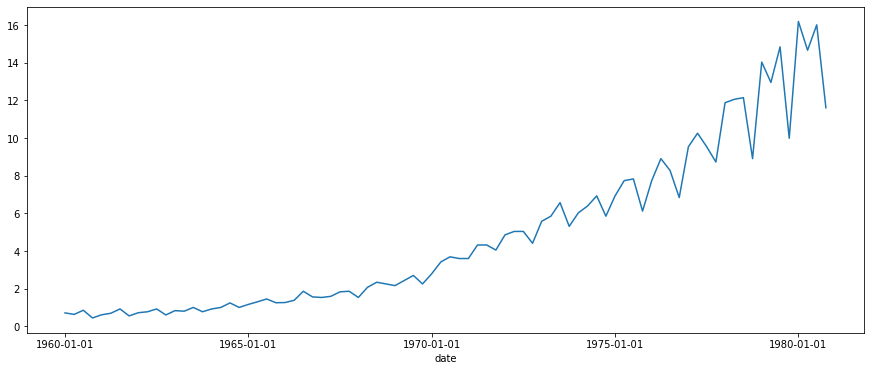

In [5]:
data['data'].plot(figsize=(15,6));

Como se aprecia en la gráfica, se presentan diferentes estadísticos a lo largo del tiempo.

A cntinuación, representaremos sus gráficas de autocorrelación, donde veremos que tenemos muy complicado determinar el orden p y q, de cara al modelo ARIMA.

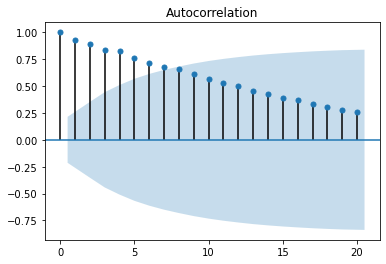

In [6]:
plot_acf(data['data']);

Dividimos en train y test. No podemos utilizar el modo basado en ``train_test_split``, ya que nos desordenaría los datos.

In [8]:
X = data['data'].values
train = X[:70]
test = X[70:]
train

array([ 0.71,  0.63,  0.85,  0.44,  0.61,  0.69,  0.92,  0.55,  0.72,
        0.77,  0.92,  0.6 ,  0.83,  0.8 ,  1.  ,  0.77,  0.92,  1.  ,
        1.24,  1.  ,  1.16,  1.3 ,  1.45,  1.25,  1.26,  1.38,  1.86,
        1.56,  1.53,  1.59,  1.83,  1.86,  1.53,  2.07,  2.34,  2.25,
        2.16,  2.43,  2.7 ,  2.25,  2.79,  3.42,  3.69,  3.6 ,  3.6 ,
        4.32,  4.32,  4.05,  4.86,  5.04,  5.04,  4.41,  5.58,  5.85,
        6.57,  5.31,  6.03,  6.39,  6.93,  5.85,  6.93,  7.74,  7.83,
        6.12,  7.74,  8.91,  8.28,  6.84,  9.54, 10.26])

## Autorregresión

Tendremos que encontrar el orden de autorregresión que mejor encaje con nuestros datos, para lo cual varairemos los parámetros hasta encontrar los que mejor se ajusten:

In [9]:
model_ar = ARIMA(order=(1, 0, 0))
model_ar_fit = model_ar.fit(train)

In [10]:
predictions = model_ar_fit.predict(14)
print("mean_squared_error:", mean_squared_error(test, predictions))
print("root mean_squared_error:", np.sqrt(mean_squared_error(test, predictions)))

mean_squared_error: 13.698850972237235
root mean_squared_error: 3.7011958840673693


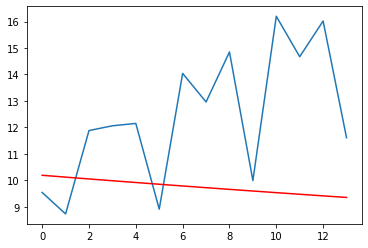

In [11]:
plt.plot(test)
plt.plot(predictions,color='red');

No parece que de buen resultado el AR(1,0,0). Probemos diferentes lags, a ver cuál sería el mejor

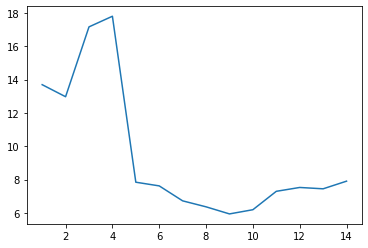

In [12]:
lags = []
mse = []
for lag in range(1, 15):
    try:
        model_ar = ARIMA(order=(lag, 0, 0))
        model_ar_fit = model_ar.fit(train)
        predictions = model_ar_fit.predict(14)
        lags.append(lag)
        mse.append(mean_squared_error(test, predictions))
        
    except:
        continue
    
plt.plot(lags, mse);

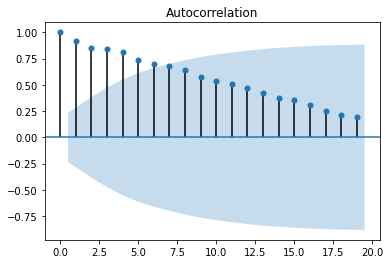

In [14]:
plot_acf(train);

Un parámetro p=1, p=2 o p=5 parece que da buen resultado, pero aun asi es muy alto el error.

## Medias móviles

En este caso tendremos en cuenta los errores. El problema es que si tenemos muchos errores al principio, los iremos arrastrando durante las predicciones.

In [15]:
model_ma = ARIMA(order=(0, 0, 1))
model_ma.fit(train)

ARIMA(order=(0, 0, 1))

In [16]:
predictions = model_ma.predict(14)
print("mean_squared_error:", mean_squared_error(test, predictions))

mean_squared_error: 87.15679101447661


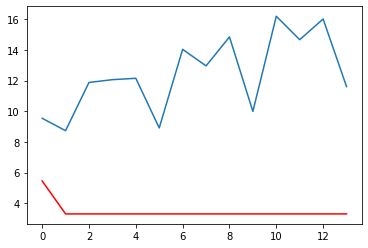

In [17]:
plt.plot(test)
plt.plot(predictions,color='red');

No está dando buen resultado. Probaremos entonces varios lags

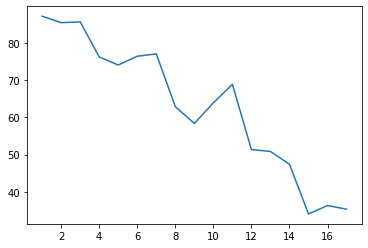

In [18]:
lags = []
mse = []
for lag in range(1, 20):
    try:
        model_ma = ARIMA(order=(0, 0, lag))
        model_ma_fit = model_ma.fit(train)
        predictions = model_ma_fit.predict(14)
        lags.append(lag)
        mse.append(mean_squared_error(test, predictions))
    except:
        continue
    
plt.plot(lags, mse);

Parece que según vamos aumentando el parámetro `q` del modelo Moving Average, va disminuyendo el error, pero aun así es bastante grande.

## ARIMA
En el modelo ARIMA no solo influyen los parámetros `p` y `q`, sino que también tendremos en cuenta `d`, parámetro con el que diferenciaremos la serie y conseguiremos que sea estacionaria.

Ahora bien, ¿cuál es la mejor combinación de parámetros? Tendremos que realizar varias pruebas. Para comparar los modelos se suele utilizar el AIC.

### AIC

Akaike’s Information Criterion (Criterio de Información de Akaike):

![imagen](./img/aic.png)

donde $k$ es el número de parámetros del modelo estadístico, y $L$ es el máximo valor de la función de verosimilitud para el modelo estimado. La función de verosimilitud permite realizar inferencias a partir de un conjunto de observaciones.

Se utiliza para seleccionar el mejor modelo, que será el que tiene menor AIC. El AIC depende mucho de cada dato, y es una medida de comparación entre modelos, no de presentación de resultados. Un AIC bajo no quiere decir que el modelo sea muy bueno. Por tanto, AIC no nos dice nada sobre la calidad del modelo en términos absolutos.


#### ¿Cómo conseguir los mejores p, d, q?

Pues probando y quedándonos con el que mejor métrica nos devuelva, que en este caso será el AIC. Para ello, generaremos las posibles combinaciones de parámetros:

In [23]:
import itertools
p=d=q=range(0,5)
pdq = list(itertools.product(p, d, q))
pdq[:3]

[(0, 0, 0), (0, 0, 1), (0, 0, 2)]

In [24]:
results = []
for param in pdq:
    try:
        model_arima = ARIMA(order=param)
        model_arima_fit = model_arima.fit(train)
        results.append((param,model_arima_fit.aic()))
    except:
        continue
    

In [25]:
resultados_df = pd.DataFrame(results, columns=['ARIMA params', 'AIC']).sort_values('AIC')
resultados_df.head()

,ARIMA params,AIC
87,"(3, 2, 2)",37.062046
111,"(4, 2, 1)",38.185617
88,"(3, 2, 3)",38.423633
112,"(4, 2, 2)",38.749495
89,"(3, 2, 4)",40.354054


Ya tenemos la mejor combinación de parámetros para el ARIMA. Probemos el modelo

In [26]:
best_model = ARIMA(order=(3,2,2))
best_model.fit(train)
best_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   70
Model:               SARIMAX(3, 2, 2)   Log Likelihood                 -11.531
Date:                Sat, 06 Mar 2021   AIC                             37.062
Time:                        05:26:55   BIC                             52.599
Sample:                             0   HQIC                            43.218
                                 - 70                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0174      0.002      7.101      0.000       0.013       0.022
ar.L1         -1.1106      0.053    -20.804      0.000      -1.215      -1.006
ar.L2         -1.0931      0.050    -21.776      0.000      -1.191      -0.995
ar.L3         -0.9539      0.041    -23.069      0.000      -1.035      -0.873
ma.L1         -0.5173      0.151     -3.434      0.001      -0.813      -0.222
ma.L2         -0.4445      0.133     -3.335      0.001      -0.706      -0.183
sigma2         0.0688      0.011      6.178      0.000       0.047       0.091
===================================================================================
Ljung-Box (Q):                       32.58   Jarque-Bera (JB):                 8.43
Prob(Q):                              0.79   Prob(JB):                         0.01
Heteroskedasticity (H):              24.87   Skew:                             0.54
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [27]:
predictions = best_model.predict(14)
print("mean_squared_error:", mean_squared_error(test, predictions))
print("root mean_squared_error:", np.sqrt(mean_squared_error(test, predictions)))

mean_squared_error: 3.9422958216423436
root mean_squared_error: 1.9855215490249265


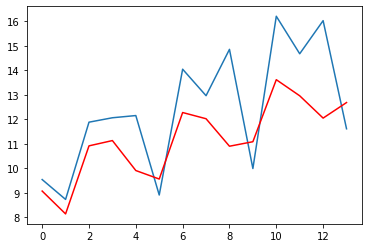

In [28]:
plt.plot(test)
plt.plot(predictions,color='red');

### Auto ARIMA

Acabamos de buscar la mejor combinación de parámetros con nuestra lógica, al igual que hicimos en su día con el ``for`` para sacar el mejor número de vecinos en un KNN. Sin embargo, así como vimos que había métodos para automatizar ese proceso, también los hay para el ARIMA: la función ``auto_arima`` que nos hemos importado de la nueva librería ``pmdarima``

In [29]:
model = auto_arima(train,
                  max_p=5,
                  max_q=5,
                  max_d=3,
                  seasonality=False,
                  trace=True,
                  stepwise=True)
print(model.aic())

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=83.049, Time=0.10 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=196.672, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=180.443, Time=0.01 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=140.942, Time=0.04 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=137.570, Time=0.15 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=113.935, Time=0.08 sec
 ARIMA(3,2,2)(0,0,0)[0]             : AIC=42.673, Time=0.18 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=47.310, Time=0.13 sec
 ARIMA(4,2,2)(0,0,0)[0]             : AIC=44.623, Time=0.35 sec
 ARIMA(3,2,3)(0,0,0)[0]             : AIC=44.530, Time=0.18 sec
 ARIMA(2,2,3)(0,0,0)[0]             : AIC=82.336, Time=0.16 sec
 ARIMA(4,2,1)(0,0,0)[0]             : AIC=44.000, Time=0.35 sec
 ARIMA(4,2,3)(0,0,0)[0]             : AIC=45.524, Time=0.38 sec
 ARIMA(3,2,2)(0,0,0)[0] intercept   : AIC=37.062, Time=0.33 sec
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=83.502, Time=0

In [30]:
model = ARIMA(order=(3,2,2))
model.fit(train)
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   70
Model:               SARIMAX(3, 2, 2)   Log Likelihood                 -11.531
Date:                Sat, 06 Mar 2021   AIC                             37.062
Time:                        05:28:43   BIC                             52.599
Sample:                             0   HQIC                            43.218
                                 - 70                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0174      0.002      7.101      0.000       0.013       0.022
ar.L1         -1.1106      0.053    -20.804      0.000      -1.215      -1.006
ar.L2         -1.0931      0.050    -21.776      0.0

In [31]:
predictions = model.predict(14)
print("mean_squared_error:", mean_squared_error(test, predictions))
print("root mean_squared_error:", np.sqrt(mean_squared_error(test, predictions)))

mean_squared_error: 3.9422958216423436
root mean_squared_error: 1.9855215490249265


## ARIMAX
La X viene de exogenous. Significa que le podemos añadir una variable externa con la que entrenar el modelo.

Vamos a probar con los datos de la bolsa. Primero, un ``auto_arima`` con los datos a cierre. Y después, un auto_arima acompañado de los datos de apertura de bolsa, a ver cuánto ayudan a predecir el cierre.

In [32]:
stock_df = pd.read_csv('data/FB.csv', header=0, index_col=0)
print(len(stock_df))
stock_df.head(20)

1259


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-12-08,76.180000,77.250000,75.400002,76.519997,76.519997,25733900
2014-12-09,75.199997,76.930000,74.779999,76.839996,76.839996,25358600
2014-12-10,76.650002,77.550003,76.070000,76.180000,76.180000,32210500
2014-12-11,76.519997,78.519997,76.480003,77.730003,77.730003,33462100
2014-12-12,77.160004,78.879997,77.019997,77.830002,77.830002,28091600
2014-12-15,78.459999,78.580002,76.559998,76.989998,76.989998,29396500
2014-12-16,76.190002,77.389999,74.589996,74.690002,74.690002,31554600
2014-12-17,75.010002,76.410004,74.900002,76.110001,76.110001,29203900
2014-12-18,76.889999,78.400002,76.510002,78.400002,78.400002,34222100


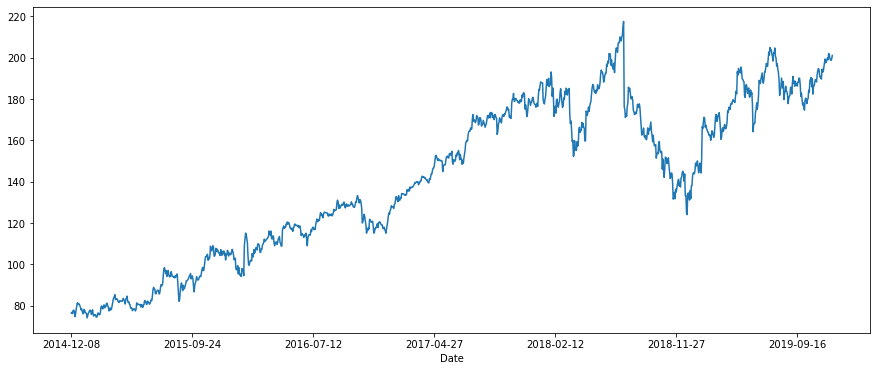

In [33]:
stock_df['Close'].plot(figsize=(15,6));

Veremos primero un ejemplo sin variable exógena:

In [34]:
train = stock_df['Close'][:1240].values
test = stock_df['Close'][1240:].values

Vamos a probar varios modelos ARIMA, a ver cuál sería la mejor combinación de hiperparámetros.

In [35]:
stepwise_model = auto_arima(train,
                            start_p=1,
                            start_q=1,
                            max_d=3,
                            max_p=5,
                            max_q=5,
                            stationary=False,
                            trace=True,
                           stepwise=True)
print(stepwise_model.aic())


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5973.080, Time=0.61 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5975.597, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5977.174, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5977.161, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5975.049, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=5974.760, Time=0.85 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.58 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=5978.841, Time=0.25 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=5978.892, Time=0.17 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.82 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=5973.656, Time=0.34 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 6.084 seconds
5973.07958068662


Ya lo tenemos, ahora montaremos el modelo con esos hiperparámetros y vemos que AIC tiene.

In [36]:
model = ARIMA(order=(1,1,1))
model.fit(train)
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1240
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -2982.540
Date:                Sat, 06 Mar 2021   AIC                           5973.080
Time:                        05:29:52   BIC                           5993.568
Sample:                             0   HQIC                          5980.785
                               - 1240                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0125      0.012      1.066      0.287      -0.010       0.035
ar.L1          0.8642      0.086     10.020      0.000       0.695       1.033
ma.L1         -0.9007      0.075    -11.985      0.0

In [37]:
predictions = model.predict(19)
print("mean_squared_error:", mean_squared_error(test, predictions))
print("root mean_squared_error:", np.sqrt(mean_squared_error(test, predictions)))

mean_squared_error: 45.026333984336645
root mean_squared_error: 6.71016646472624


Vamos ahora a compararlo con el mismo modelo, pero en este caso le añadimos una variable exógena al entrenamiento:

In [38]:
model = ARIMA(order=(1,1,1))
model.fit(train,
         exogenous=stock_df['Open'][:1240].values.reshape(-1,1))
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1240
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -2601.451
Date:                Sat, 06 Mar 2021   AIC                           5212.901
Time:                        05:30:03   BIC                           5238.511
Sample:                             0   HQIC                          5222.533
                               - 1240                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0003      0.000      1.031      0.303      -0.000       0.001
x1             0.9972      0.003    386.756      0.000       0.992       1.002
ar.L1         -0.1288      0.024     -5.445      0.0

Como podemos comprobar, se reduce bastante el AIC.

Probemos a entrenar el ``auto_arima`` con la variable exógena (parámetro ``exogenous``):

In [39]:
model = auto_arima(train,
                  max_p=5,
                  max_q=5,
                  max_d=3,
                  stationary=False,
                  trace=True,
                  stepwise=True,
                  exogenous = stock_df['Open'][:1240].values.reshape(-1,1))

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=5209.411, Time=1.83 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=5226.894, Time=0.29 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=5207.698, Time=0.11 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=5206.018, Time=0.69 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=5225.469, Time=0.51 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=5206.237, Time=0.37 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=5206.773, Time=0.92 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=5208.632, Time=2.11 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=5204.065, Time=0.27 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=5204.309, Time=0.75 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=5204.812, Time=0.45 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=5205.764, Time=0.07 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=5206.973, Time=0.84 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0]          
Total fit time: 9.237 seconds
                      

Ya que lo hemos visto con una, probemos a utilizar diferentes variables exógenas:

NOTA: para este apartado se utiliza el valor 'Low', aunque en la vida real no lo tendríamos para realizar la predicción.

In [43]:
stock_df[['Open', 'Low']][:1240].values

array([[ 76.18    ,  75.400002],
       [ 75.199997,  74.779999],
       [ 76.650002,  76.07    ],
       ...,
       [194.029999, 191.350006],
       [191.910004, 189.470001],
       [190.      , 189.699997]])

In [44]:
stock_df['Open'][:1240].values.reshape(-1,1)

array([[ 76.18    ],
       [ 75.199997],
       [ 76.650002],
       ...,
       [194.029999],
       [191.910004],
       [190.      ]])

In [45]:
model = auto_arima(train,
                  max_p=5,
                  max_q=5,
                  max_d=3,
                  stationary=False,
                  trace=True,
                  stepwise=True,
                  exogenous = stock_df[['Open', 'Low']][:1240].values)

print(model.summary())

print(model.aic())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4077.184, Time=2.57 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4733.379, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4453.973, Time=0.27 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4086.215, Time=0.60 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4731.700, Time=0.35 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4090.146, Time=1.20 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4077.060, Time=0.97 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4082.122, Time=1.31 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=4265.464, Time=0.37 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=4075.150, Time=1.78 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=4201.107, Time=0.50 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=4076.431, Time=1.94 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=4076.730, Time=2.30 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=4177.095, Time=0.64 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept

## SARIMA

En el caso de presentar estacionalidad, es decir, que cuentan con un patrón que se repite a lo largo del tiempo; los datos pueden tratarse con un modelo SARIMA:

In [46]:
df = pd.read_csv('data/a10.csv', parse_dates=['date'], index_col='date')
print(len(df))
df.head()

204


,value
date,
1991-07-01,3.526591
1991-08-01,3.180891
1991-09-01,3.252221
1991-10-01,3.611003
1991-11-01,3.565869


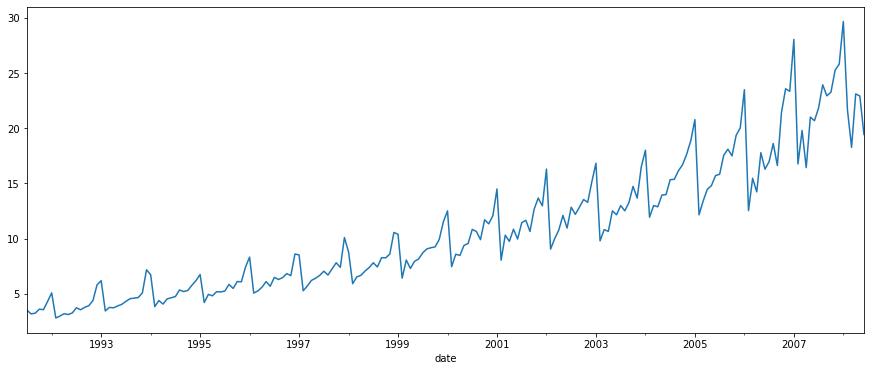

In [47]:
df['value'].plot(figsize=(15,6));

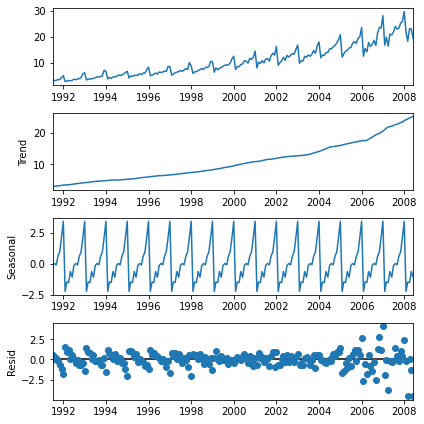

In [48]:
from statsmodels.tsa.seasonal import seasonal_decompose

result_add = seasonal_decompose(df[['value' ]], model='additive', extrapolate_trend='freq')

# Plot
plt.rcParams.update({'figure.figsize': (6,6)})
result_add.plot();

In [49]:
X = df[['value']]
train = X[:-20]
test = X[-20:]

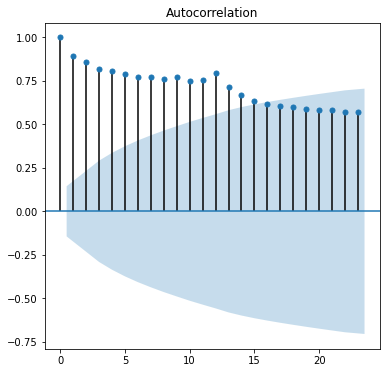

In [50]:
plot_acf(train);

Probemos el auto arima sin indicarle que hay componente de seasonality:

In [52]:
model = auto_arima(train,
                    start_p=1,
                    start_q=1,
                    max_d=3,
                    max_p=5,
                    max_q=5,
                    trace=True,
                    stepwise=True,
                    random_state=42)

print(model.aic())

predictions = model.predict(20)
print("mean_squared_error:", mean_squared_error(test, predictions))

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=698.391, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=764.142, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=739.394, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=708.405, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=762.612, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=700.332, Time=0.18 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=700.362, Time=0.19 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=699.998, Time=0.11 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=736.404, Time=0.05 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=695.600, Time=0.31 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=697.194, Time=0.41 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=697.299, Time=0.45 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=700.821, Time=0.33 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=699.306, Time=0.27 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=689.9

In [53]:
print("root mean_squared_error:", np.sqrt(mean_squared_error(test, predictions)))

root mean_squared_error: 4.637352585116349


Ahora le añadimos el componente seasonality mediante el parámetro `m`, que en este caso serán los 12 meses:

In [54]:
model = auto_arima(train,
                    start_p=1,
                    start_q=1,
                    max_d=3,
                    max_p=5,
                    max_q=5,
                    m=12,
                    seasonal=True,
                    trace=True,
                    stepwise=True,
                    random_state=42)


print(model.aic())

predictions = model.predict(20)
print("mean_squared_error:", mean_squared_error(test, predictions))

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=359.383, Time=0.58 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=480.967, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=391.380, Time=0.14 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=366.538, Time=0.37 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=357.778, Time=0.39 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=367.053, Time=0.09 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=358.591, Time=1.46 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=361.813, Time=0.25 sec
 ARIMA(1,1,1)(1,1,2)[12]             : AIC=357.470, Time=2.70 sec
 ARIMA(1,1,1)(2,1,2)[12]             : AIC=356.290, Time=1.82 sec
 ARIMA(1,1,1)(2,1,1)[12]             : AIC=354.319, Time=1.32 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=353.117, Time=0.64 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=362.795, Time=0.80 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=378.264, Time=0.48 sec
 ARIMA(2,1,1)(2,1,0)[12]         

In [55]:
print("root mean_squared_error:", np.sqrt(mean_squared_error(test, predictions)))

root mean_squared_error: 3.1632045175328263


Como se puede comprobar, hemos conseguido mejorar el resultado respecto al resto de modelos.